This notebook shows the scripts to load data and plotting the Polarimetric phase curve.


In [1]:
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'     

In [2]:
from io import StringIO
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt
from matplotlib import rcParams

import ysvisutilpy2005ud as yvu
import polutil2005ud as util

In [3]:
# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
rcParams.update({'font.size':15})

In [4]:
dats_ast = util.dats_ast
dats = util.dats
fitfunc = util.trigp

DATAPATH = util.DATAPATH
SAVEPATH = util.SAVEPATH
alpha_msi = util.alpha_msi
polr_msi = util.polr_msi
dpolr_msi = util.dpolr_msi
alpha_oth = util.alpha_oth
polr_oth = util.polr_oth
dpolr_oth = util.dpolr_oth

popt_ud, _, pol_ud, _ = util.cfit_pol(fitfunc, "trigp_f", util.dats, use_error=True)

xx = np.arange(0.1, 160, 0.1)
xx_plot = np.arange(0.1, 120, 0.1)

pol_g = dats_ast.groupby("reference")
phae_2016 = dats_ast.loc[(dats_ast['label'] == "Phaethon") 
                   &(dats_ast['reference'].isin(["2018NatCo...9.2486I"]))]
phae_2017 = dats_ast.loc[(dats_ast['label'] == "Phaethon") 
                   &(dats_ast['reference'].isin(["2018ApJ...864L..33S", "2018MNRAS.479.3498D"]))]

popt_2016, _, pol_phae_2016, _ = util.cfit_pol(fitfunc, "trigp_f", phae_2016, use_error=True)
popt_2017, _, pol_phae_2017, _ = util.cfit_pol(fitfunc, "trigp_f", phae_2017, use_error=True)

kws = {
# B-type
    "2018ApJ...864L..33S": dict(label="Phaethon 2017 (Shinnaka+18)", marker='D', mfc='none', ms=4, color='dodgerblue', alpha=0.8),
    "2018MNRAS.479.3498D": dict(label="Phaethon 2017 (Devogèle+18)", marker='s', mfc='none', ms=5, color='dodgerblue', alpha=0.8),
    "2018NatCo...9.2486I": dict(label="Phaethon 2016 (Ito+18)"     , marker='P', mfc='none', ms=7, color='b', alpha=1),
# S-types
    "1995Icar..113..200L": dict(label="Toutatis      (Lupishko+95)", marker='1', mfc='none', ms=6, color='gray'),
    "1997Icar..127..452M": dict(label="Toutatis      (Mukai+97)"   , marker='2', mfc='none', ms=6, color='gray'),
    "1997PASJ...49L..31I": dict(label="Toutatis      (Ishiguro+97)", marker='3', mfc='none', ms=6, color='gray'),
    "2017AJ....154..180I": dict(label="Icarus        (Ishiguro+17)", marker='D', mfc='none', ms=5, color='lime'),
# C-types
    "2018MNRAS.481L..49C": dict(label="Bennu         (Cellino+18)" , marker='s', mfc='none', ms=5, color='k'),
    "2018A&A...611A..31K": dict(label="1999 KU2      (Kuroda+18)"  , marker='d', mfc='none', ms=5, color='k'),
    "1999Icar..140..464K": dict(label="Ra-Shalom     (Kiselev+99)" , marker='D', mfc='none', ms=5, color='k'),
    "KurodaD2021arXiv": dict(label="Ryugu         (Kuroda+21)" , marker='s', mfc='k', ms=3, color='k'),
}

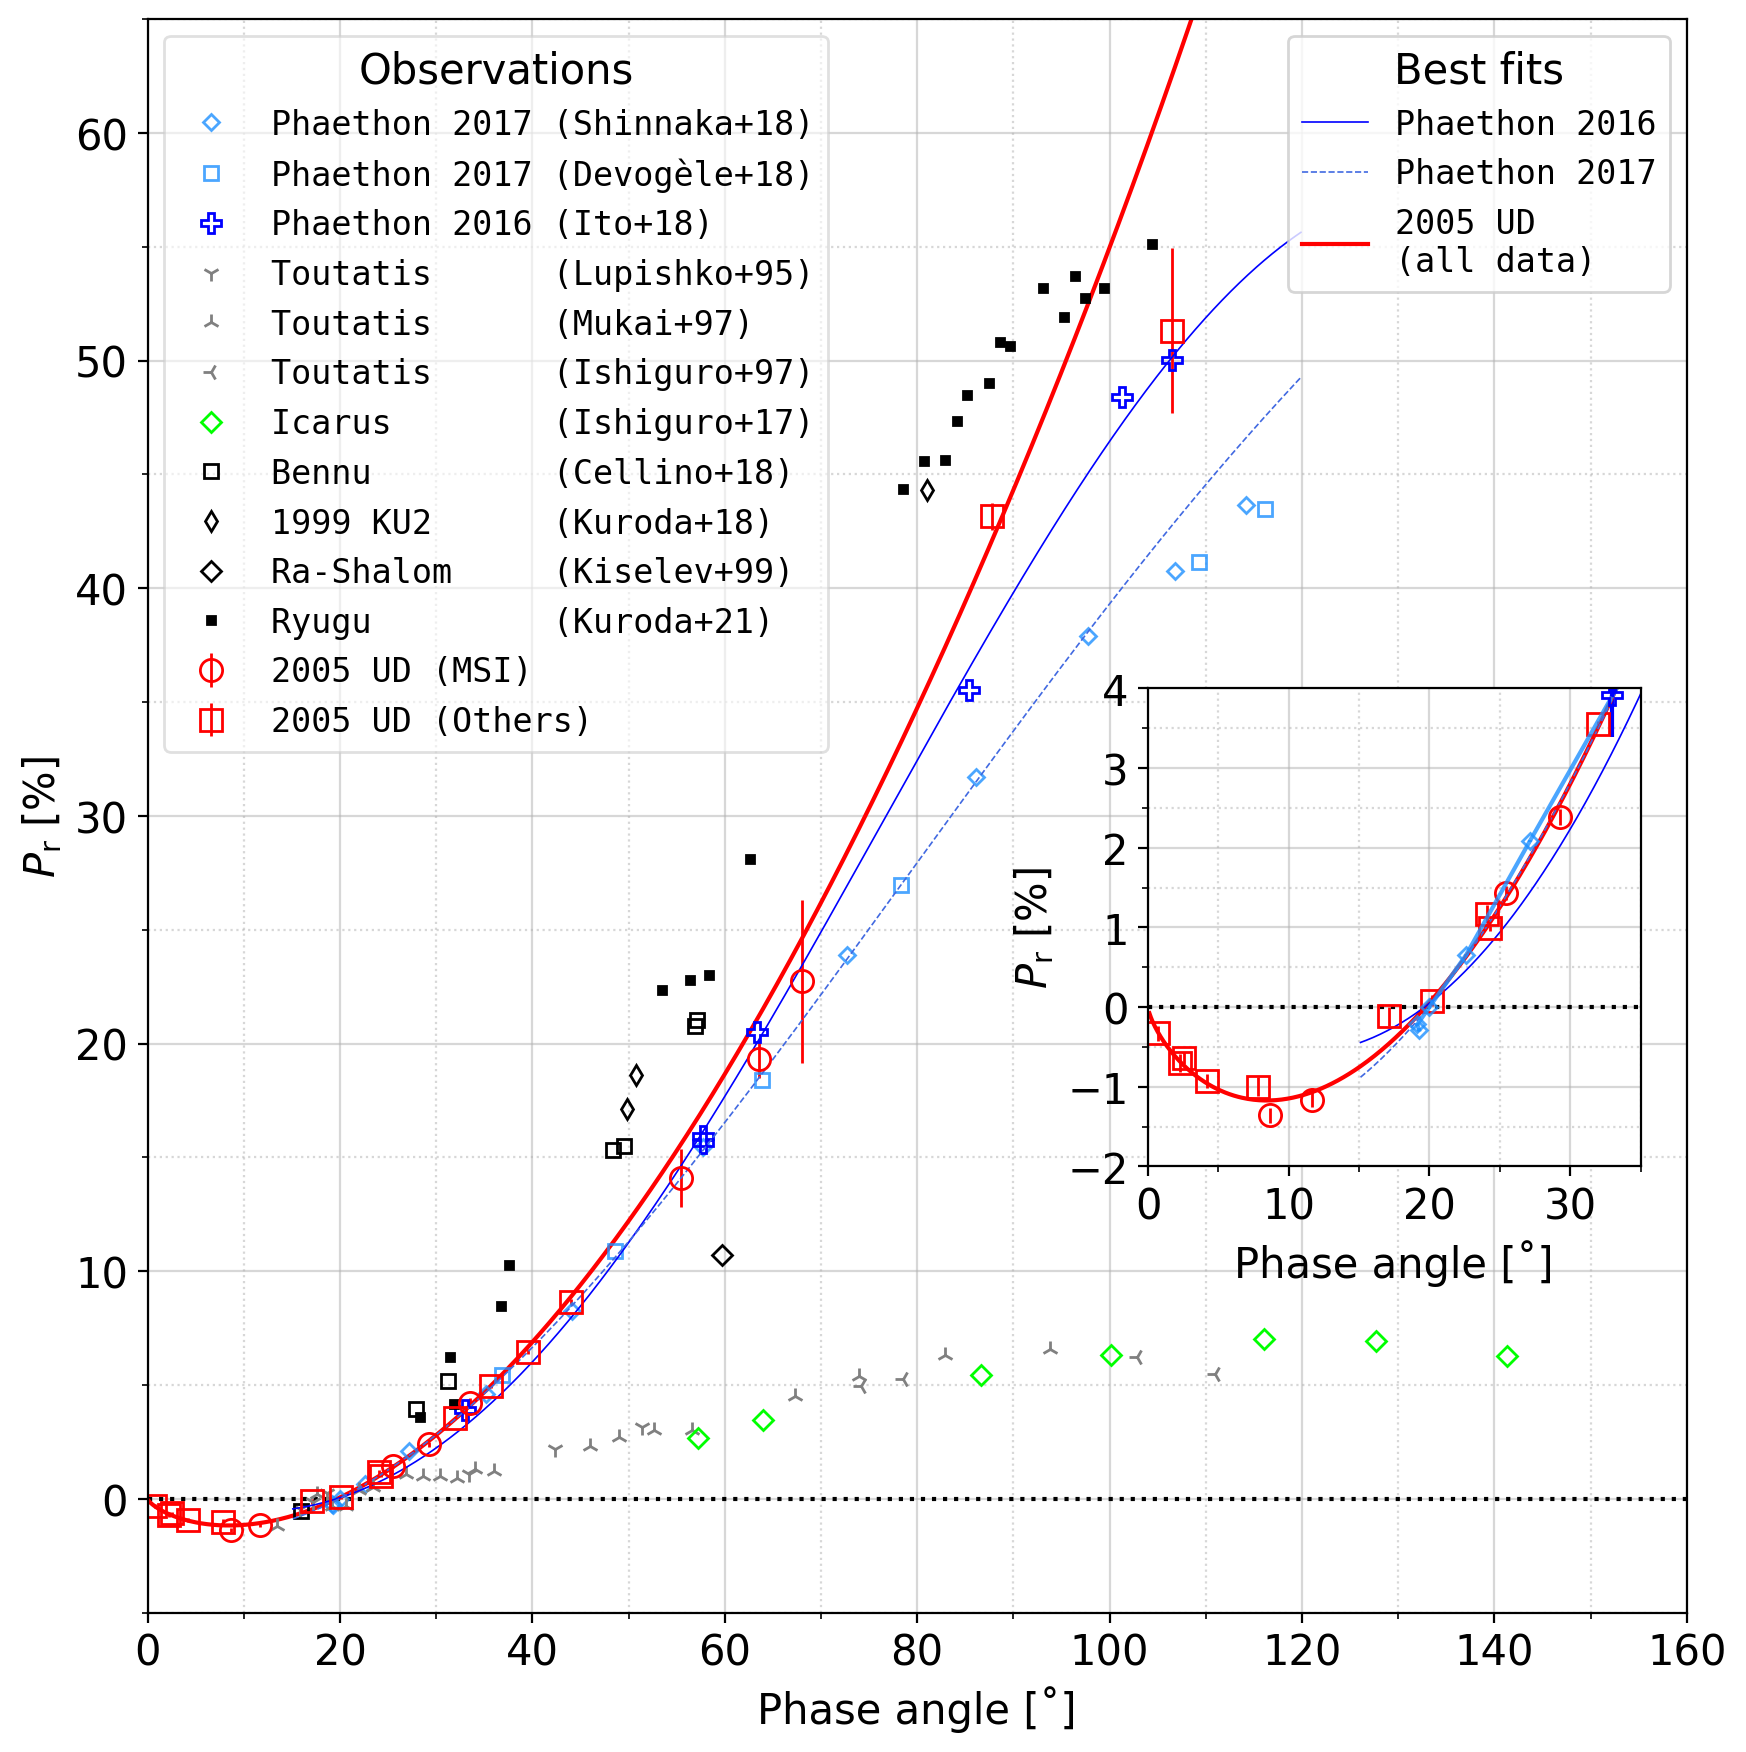

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(9, 9), 
                        sharex=False, sharey=False, gridspec_kw=None)
ax0 = axs
ax1 = ax0.twinx()  # ghost axes
ax1.axis('off')
axi = ax0.inset_axes([0.65, 0.28, 0.32, 0.30])
util.plot_data(
    np.array([ax0, axi]), 
    ylims=[(-5, 65), (-2, 4)], 
    mkw_msi=dict(color='r', marker='o', ms=8, mfc='none', label="2005 UD (MSI)"),
    mkw_oth=dict(color='r', marker='s', ms=8, mfc='none', label="2005 UD (Others)")
)

[ax.plot(xx_plot, fitfunc(xx_plot, *popt_ud), color='r') for ax in [ax0, axi]]


for ref, kw in kws.items():
    g = pol_g.get_group(ref)
    ax0.plot(g.alpha, g.Pr, ls='', **kws[ref])
#     axi.plot(g.alpha, g.Pr, ls='', **kws[ref])
    if kw['label'].startswith("Phaethon"):
        axi.errorbar(g.alpha, g.Pr, g.dPr, **kws[ref])

for popt, ls, c, y in zip([popt_2016, popt_2017], ['-', '--'], ['b', 'royalblue'], ['2016', '2017']):
    [ax.plot(xx_plot[150:], fitfunc(xx_plot[150:], *popt), ls=ls, color=c, lw=0.6) for ax in [ax0, axi]]
    ax1.plot(np.nan, np.nan, ls=ls, color=c, lw=0.6, label=f"Phaethon {y}")
#     ax0.text(xx_plot[-1] + 5, fitfunc(xx_plot, *popt)[-1], f"Phaethon\n{y}", color=c)
# ax0.text(110, 63, "2005 UD", color='r')

ax1.plot(np.nan, np.nan, 'r-', label=f"2005 UD\n(all data)")

ax0.legend(loc=2, title="Observations", prop={'family': 'monospace', 'size': 12}, framealpha=0.6)
ax1.legend(loc=1, title="Best fits", prop={'family': 'monospace', 'size': 12})
plt.tight_layout()
plt.savefig(SAVEPATH/"phasecurve.pdf")